# Property time in market - (time2event prediction)

In [284]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines.fitters.coxph_fitter import CoxPHFitter

In [285]:
df = pd.read_excel(r'C:\Users\Lenovo\Documents\_Datasets\Properties\liquidity_challenge.xlsx')

## 1. Data processing

In [286]:
pd.set_option('display.max_columns', None)
df.head()

,property_id,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,first_price,last_price,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,069c4d09-1f4e-4451-bf9f-23130537bb37,1,96,apartment,120.0,2.5,2.0,-2.900368e+18,-7946976479905633280,1.0,4100000.0,4100000.0,-99.197758,19.377609,51,1,2023-06-04 04:01:08,2023-09-09 04:01:07,0,1,0,0,0,0,0,0,0,0,0
1,0a4c5851-88ae-4d33-8fb7-f7d50ca85389,0,37,apartment,82.0,2.0,2.0,8.261012e+18,1284474136562356992,2.0,4900000.0,4900000.0,-99.183100,19.402272,61,1,2023-09-09 01:06:12,2023-10-09 16:29:27,1,1,0,0,0,0,0,1,1,0,0
2,9d31a760-0ffd-44df-b77e-28fe6e1b019d,1,88,apartment,84.0,2.0,2.0,1.657070e+18,-3834970849644356096,1.0,2782696.0,2782696.0,-99.114488,19.399742,50,3,2023-07-05 18:47:41,2023-10-02 16:19:31,0,0,0,0,0,0,0,0,0,0,0
3,fb141128-2a00-4117-929d-ca7ef507d2ab,1,58,apartment,92.0,2.0,2.0,-2.900368e+18,-7946976479905633280,0.0,5280000.0,5280000.0,-99.176732,19.395337,68,2,2023-04-13 23:52:15,2023-06-11 04:01:48,1,1,0,0,0,0,0,1,0,0,0
4,b334cf18-5c23-4914-947a-d545c439845f,0,95,apartment,55.0,1.0,1.0,8.261012e+18,377027056504647872,1.0,3250000.0,3250000.0,-99.145629,19.433646,58,6,2023-07-12 22:27:30,2023-10-09 16:17:00,0,1,1,1,0,1,0,1,1,0,0


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   property_id                   4740 non-null   object        
 1   event                         4740 non-null   int64         
 2   time2event                    4740 non-null   int64         
 3   property_type                 4740 non-null   object        
 4   surface_total                 4740 non-null   float64       
 5   num_bathrooms                 4645 non-null   float64       
 6   num_bedrooms                  4646 non-null   float64       
 7   marketplace_hash              4645 non-null   float64       
 8   seller_hash                   4740 non-null   int64         
 9   num_parking_lots              4645 non-null   float64       
 10  first_price                   4740 non-null   float64       
 11  last_price                    

In [288]:
df[['marketplace_hash', 'seller_hash']] = df[['marketplace_hash', 'seller_hash']].astype('object')

In [289]:
df.isnull().sum()

property_id                      0
event                            0
time2event                       0
property_type                    0
surface_total                    0
num_bathrooms                   95
num_bedrooms                    94
marketplace_hash                95
seller_hash                      0
num_parking_lots                95
first_price                      0
last_price                       0
longitude                        0
latitude                         0
views                            0
num_marketplaces_property_at     0
first_observed_date              0
last_observed_date               0
has_balcony                      0
has_elevator                     0
has_garden                       0
has_gym                          0
has_luxury_features              0
has_pool                         0
has_studio                       0
has_surveillance                 0
has_terrace                      0
has_visitors_parking             0
has_washing_area    

In [290]:
# Analyze 'property_type' categories
df['property_type'].value_counts()

property_type
apartment    3464
house        1276
Name: count, dtype: int64

In [291]:
df.describe()

,event,time2event,surface_total,num_bathrooms,num_bedrooms,num_parking_lots,first_price,last_price,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
count,4740.000000,4740.000000,4740.000000,4645.000000,4646.000000,4645.000000,4.740000e+03,4.740000e+03,4740.000000,4740.000000,4740.000000,4740.000000,4740,4740,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.596414,65.138819,174.351380,2.253606,2.602884,1.985834,7.672510e+06,7.671930e+06,-99.183039,19.382338,53.562025,2.805485,2023-06-23 08:41:36.925316352,2023-08-26 08:52:28.804641280,0.260759,0.422574,0.345781,0.277848,0.001899,0.167089,0.075105,0.566456,0.439873,0.012236,0.295148
min,0.000000,6.000000,27.000000,1.000000,0.000000,0.000000,1.100000e+06,1.050000e+06,-99.329198,19.210562,0.000000,1.000000,2023-03-01 00:26:25,2023-03-10 21:00:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,76.000000,2.000000,2.000000,1.000000,3.484780e+06,3.480831e+06,-99.211401,19.351280,43.000000,1.000000,2023-05-13 02:42:33.500000,2023-07-17 23:14:38.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,55.500000,115.000000,2.000000,2.000000,2.000000,5.550794e+06,5.545750e+06,-99.176696,19.381730,54.000000,2.000000,2023-06-19 20:12:48,2023-09-11 19:06:06.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,91.000000,219.000000,3.000000,3.000000,2.000000,9.451250e+06,9.400000e+06,-99.152366,19.416898,68.000000,3.000000,2023-08-08 01:27:06,2023-10-09 17:32:44,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,178.000000,1350.000000,15.000000,6.000000,10.000000,4.100000e+07,1.044196e+08,-99.007713,19.552514,105.000000,20.000000,2023-10-10 00:34:56,2023-10-16 18:24:06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.490668,42.384843,154.220601,1.011588,0.930562,1.193088,6.599707e+06,6.736482e+06,0.049769,0.051527,19.111410,2.847190,NaN,NaN,0.439095,0.494021,0.475672,0.447985,0.043538,0.373094,0.263589,0.495616,0.496424,0.109950,0.456157


In [292]:
df.describe(include='object')

,property_id,property_type,marketplace_hash,seller_hash
count,4740,4740,4.645000e+03,4740
unique,4740,2,8.000000e+00,713
top,069c4d09-1f4e-4451-bf9f-23130537bb37,apartment,8.261012e+18,377027056504647872
freq,1,3464,1.565000e+03,1563


In [293]:
# Removing unnecesary variables that doesn't affect time2event
df.drop(columns=['property_id'], inplace=True)

It could be considered that the following variables are not correlated to time2event, but they are going to be analyzed as they could affect indirectly: 
* marketplace_hash
* seller_hash



In [294]:
df.groupby(['seller_hash'], as_index=False)['time2event'].mean().sort_values('time2event', ascending=False)

,seller_hash,time2event
203,-3360937248848343040,173.0
146,-5044457229517483008,172.5
99,-6380261238330616832,172.5
659,7966113346199360512,172.0
384,1393102038750145024,166.0
...,...,...
362,797619241062466176,13.0
283,-1447896062751783936,12.0
374,1145233659307577984,8.0
6,-9040851303670739968,6.0


In [295]:
df.groupby(['marketplace_hash'], as_index=False)['time2event'].mean().sort_values('time2event', ascending=False)

,marketplace_hash,time2event
0,-8593032714103325696.0,86.933333
3,-1055582272576819968.0,82.096335
1,-2900368119329458176.0,75.435065
4,1657069623777658112.0,62.949672
7,8261012051854438400.0,62.345048
2,-2809056857135862784.0,60.000000
6,6901946972740168704.0,54.857143
5,6474342183352086528.0,52.353414


This indicates that there are sellers and marketplaces with different values for time2event, so they will be considered for analysis.

But these variables will be converted into labels with LabelEncoder.

In [296]:
from sklearn.preprocessing import LabelEncoder

# Getting the name of the columns for categorical variables
categorical_columns = df.describe(include='object').columns

encoder = LabelEncoder()

# Converting categorical columns values into numbers (Label encoding)
for column in categorical_columns:
    df[column] = encoder.fit_transform(df[column].astype(str))

### Analyzing and cleaning null values

In [297]:
df[df['num_bathrooms'].isnull() | df['num_bedrooms'].isnull() | df['num_parking_lots'].isnull()].shape


(278, 28)

In [298]:
df['num_bathrooms'].value_counts()

num_bathrooms
2.0     2164
1.0      949
3.0      710
4.0      283
2.5      177
3.5      150
5.0       82
4.5       51
1.5       34
6.0       28
5.5       16
15.0       1
Name: count, dtype: int64

<BarContainer object of 12 artists>

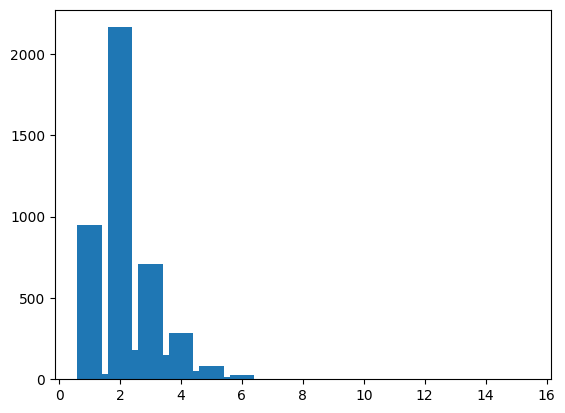

In [299]:
plt.bar(df['num_bathrooms'].value_counts().index, df['num_bathrooms'].value_counts().values)

<BarContainer object of 12 artists>

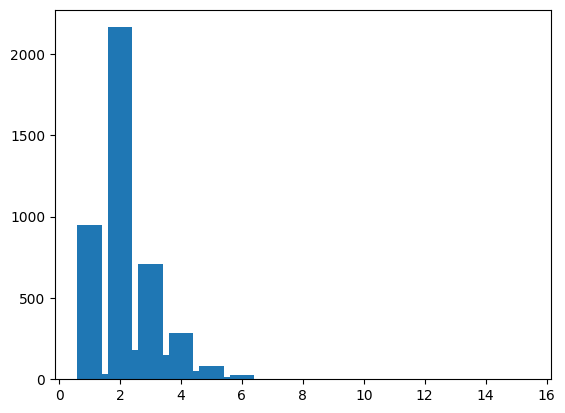

In [300]:
plt.bar(df['num_bathrooms'].value_counts().index, df['num_bathrooms'].value_counts().values)

<BarContainer object of 27 artists>

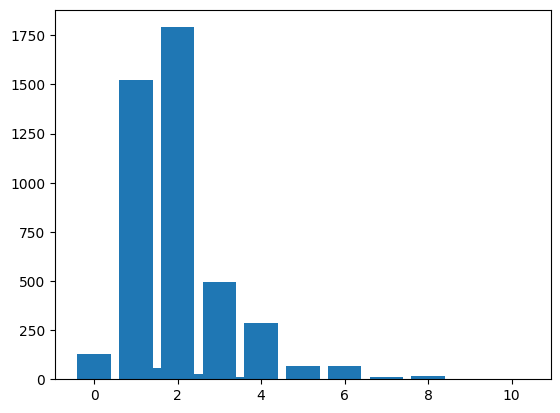

In [301]:
plt.bar(df['num_parking_lots'].value_counts().index, df['num_parking_lots'].value_counts().values)

In [302]:
# pd.set_option('display.max_rows', None)
df[df['num_bathrooms'].isnull() | df['num_bedrooms'].isnull() | df['num_parking_lots'].isnull()].head(10)
# pd.set_option('display.max_rows', 60)

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,first_price,last_price,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
33,1,27,0,54.0,1.0,2.0,4,461,NaN,1.590000e+06,1590000.0,-99.131709,19.422203,99,1,2023-05-30 23:54:49,2023-06-27 04:18:32,0,0,0,0,0,0,0,0,0,0,0
74,0,41,0,95.0,2.0,NaN,5,638,1.0,6.743225e+06,6743225.0,-99.162992,19.423931,59,2,2023-09-04 20:20:57,2023-10-09 18:23:23,0,0,0,0,0,0,0,0,0,0,0
109,1,25,1,230.0,3.0,NaN,4,461,3.0,6.900000e+06,6900000.0,-99.134893,19.290818,64,1,2023-06-08 06:58:21,2023-07-04 05:05:30,0,0,1,0,0,0,1,0,0,0,0
114,1,61,0,49.0,1.0,NaN,5,312,1.0,1.770000e+06,1770000.0,-99.120710,19.390620,55,3,2023-04-04 00:50:37,2023-06-04 04:10:30,0,0,0,0,0,0,0,0,0,0,0
145,0,137,1,735.0,NaN,4.0,0,503,4.0,2.657442e+07,30000000.0,-99.261433,19.389506,35,2,2023-05-31 22:36:56,2023-10-16 17:07:58,1,0,1,0,0,0,0,1,0,0,0
157,0,21,0,123.0,2.0,2.0,4,461,NaN,6.800000e+06,6800000.0,-99.212477,19.433370,44,2,2023-09-25 01:06:00,2023-10-09 16:21:31,0,1,0,0,0,0,0,0,0,0,0
158,0,135,0,76.0,2.0,NaN,7,495,1.0,3.876000e+06,3876000.0,-99.169567,19.430641,57,1,2023-06-03 06:24:30,2023-10-09 16:18:29,0,1,0,0,0,0,0,0,0,0,0
187,1,21,0,90.0,NaN,2.0,4,132,2.0,5.012919e+06,5012919.0,-99.218984,19.339229,0,13,2023-09-11 01:40:19,2023-10-02 16:05:15,0,0,0,1,0,0,0,1,1,0,0
199,0,47,0,80.0,2.0,2.0,0,247,NaN,4.480000e+06,4480000.0,-99.167130,19.392554,53,2,2023-08-29 17:24:06,2023-10-16 16:06:35,0,1,0,0,0,0,0,1,1,0,0
210,1,48,0,133.0,NaN,3.0,4,312,3.0,8.000070e+06,8000070.0,-99.200512,19.443241,54,1,2023-06-21 04:06:28,2023-08-08 04:20:34,0,1,0,1,0,1,0,0,1,0,0


There is no relation or pattern found in the NaN values for bedrooms or bathrooms. As NaN values represent slighlty more than 5% of the values, the ebst strategy would be to replace by the mode value.

In [303]:
# Replacing for the Mode value which is 2.0
df.loc[df['num_bathrooms'].isnull(), 'num_bathrooms'] = 2.0
df.loc[df['num_bedrooms'].isnull(), 'num_bedrooms'] = 2.0
df.loc[df['num_parking_lots'].isnull(), 'num_parking_lots'] = 2.0

# Replacing for a new category as "Unknown"
df.loc[df['marketplace_hash'].isnull(), 'marketplace_hash'] = 'Unknown'

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_39420\3834324263.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[df['marketplace_hash'].isnull(), 'marketplace_hash'] = 'Unknown'


In [304]:
df.isna().sum()

event                           0
time2event                      0
property_type                   0
surface_total                   0
num_bathrooms                   0
num_bedrooms                    0
marketplace_hash                0
seller_hash                     0
num_parking_lots                0
first_price                     0
last_price                      0
longitude                       0
latitude                        0
views                           0
num_marketplaces_property_at    0
first_observed_date             0
last_observed_date              0
has_balcony                     0
has_elevator                    0
has_garden                      0
has_gym                         0
has_luxury_features             0
has_pool                        0
has_studio                      0
has_surveillance                0
has_terrace                     0
has_visitors_parking            0
has_washing_area                0
dtype: int64

Now there are no null values anymore.

### Feature engineering

Converting first_price and last_price into millions to simplify further analysis

In [305]:
df['first_price'] = df['first_price'] / 1e6
df['last_price'] = df['last_price'] / 1e6

In [306]:
df.describe()

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,seller_hash,num_parking_lots,first_price,last_price,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
count,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.00000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740,4740,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000,4740.000000
mean,0.596414,65.138819,0.269198,174.351380,2.248523,2.590928,388.88038,1.986118,7.672510,7.671930,-99.183039,19.382338,53.562025,2.805485,2023-06-23 08:41:36.925316352,2023-08-26 08:52:28.804641280,0.260759,0.422574,0.345781,0.277848,0.001899,0.167089,0.075105,0.566456,0.439873,0.012236,0.295148
min,0.000000,6.000000,0.000000,27.000000,1.000000,0.000000,0.00000,0.000000,1.100000,1.050000,-99.329198,19.210562,0.000000,1.000000,2023-03-01 00:26:25,2023-03-10 21:00:33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,29.000000,0.000000,76.000000,2.000000,2.000000,278.00000,1.000000,3.484780,3.480831,-99.211401,19.351280,43.000000,1.000000,2023-05-13 02:42:33.500000,2023-07-17 23:14:38.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,55.500000,0.000000,115.000000,2.000000,2.000000,461.00000,2.000000,5.550795,5.545750,-99.176696,19.381730,54.000000,2.000000,2023-06-19 20:12:48,2023-09-11 19:06:06.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,91.000000,1.000000,219.000000,3.000000,3.000000,461.00000,2.000000,9.451250,9.400000,-99.152366,19.416898,68.000000,3.000000,2023-08-08 01:27:06,2023-10-09 17:32:44,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,178.000000,1.000000,1350.000000,15.000000,6.000000,712.00000,10.000000,41.000000,104.419615,-99.007713,19.552514,105.000000,20.000000,2023-10-10 00:34:56,2023-10-16 18:24:06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,0.490668,42.384843,0.443590,154.220601,1.002028,0.925114,169.62931,1.181071,6.599707,6.736482,0.049769,0.051527,19.111410,2.847190,NaN,NaN,0.439095,0.494021,0.475672,0.447985,0.043538,0.373094,0.263589,0.495616,0.496424,0.109950,0.456157


In [307]:
#Analyzing the top values for 'first_price' 
df['first_price'].sort_values(ascending=False).head()

4390    41.00
4453    40.70
2415    40.00
1317    39.95
2283    39.90
Name: first_price, dtype: float64

In [308]:
#Analyzing the top values for 'last_price' 
df['last_price'].sort_values(ascending=False).head()

91      104.419615
1583     41.027000
4390     41.000000
4453     40.700000
827      40.197265
Name: last_price, dtype: float64

In [309]:
df.loc[[91]]

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,first_price,last_price,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
91,1,95,1,805.0,4.0,4.0,7,461,1.4,5.95,104.419615,-99.26115,19.350184,37,4,2023-06-08 01:16:38,2023-09-11 19:45:01,0,0,1,1,0,1,0,1,1,0,0


Now, a new variable will be created based on first_price and last_price. It will be 'price_change_pct', as it will indicate if the original price was increased (or decreased), and 'first_price' will be dropped, as it would be redundant. 

This relative change will be positive values for prices increases and negative values for price decreases, so this could be helpful for the esitmation of time2event.

In [310]:
df['price_change_pct'] = (df['last_price'] - df['first_price']) / df['first_price']

In [311]:
# Reordering columns in the DataFrame and also removing the 'first_price' column

columns_order = ['event', 'time2event', 'property_type', 'surface_total',
       'num_bathrooms', 'num_bedrooms', 'marketplace_hash', 'seller_hash',
       'num_parking_lots', 'last_price', 'price_change_pct', 'longitude',
       'latitude', 'views', 'num_marketplaces_property_at',
       'first_observed_date', 'last_observed_date', 'has_balcony',
       'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features',
       'has_pool', 'has_studio', 'has_surveillance', 'has_terrace',
       'has_visitors_parking', 'has_washing_area']

df = df[columns_order]

In [312]:
#Analyzing the price_change_pct values for some records
df[df['price_change_pct'] != 0].head()

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,last_price,price_change_pct,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
8,1,85,0,77.0,2.0,2.0,7,26,2.0,5.500000,-0.500000,-99.200731,19.443135,54,1,2023-06-11 01:09:08,2023-09-04 18:32:44,0,1,1,1,0,1,0,1,1,0,0
13,1,171,0,207.0,3.5,3.0,0,681,2.0,14.800000,0.156250,-99.214268,19.431386,44,1,2023-04-14 12:18:08,2023-10-02 18:12:50,1,1,1,0,0,0,1,1,1,0,1
14,1,26,0,67.0,2.0,2.0,7,638,1.0,4.650003,0.009334,-99.174955,19.362579,79,1,2023-07-12 01:11:57,2023-08-07 19:49:29,0,0,0,0,0,0,0,1,0,0,1
17,1,162,0,66.0,2.0,2.0,7,682,1.0,2.900000,-0.016949,-99.139951,19.358549,45,10,2023-04-23 01:25:11,2023-10-02 16:15:51,0,1,0,0,0,0,0,1,1,0,1
19,0,123,0,67.7,1.0,2.0,0,522,1.0,2.790000,-0.027875,-99.144232,19.375412,65,1,2023-06-15 14:35:34,2023-10-16 16:05:40,0,0,0,0,0,0,0,0,0,0,0


In [313]:
df.loc[[91]]

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,last_price,price_change_pct,longitude,latitude,views,num_marketplaces_property_at,first_observed_date,last_observed_date,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
91,1,95,1,805.0,4.0,4.0,7,461,1.4,104.419615,16.549515,-99.26115,19.350184,37,4,2023-06-08 01:16:38,2023-09-11 19:45:01,0,0,1,1,0,1,0,1,1,0,0


A change from 6 M USD to 104 M USD with a 1,654% increase is extremely unusual, and there's a high probability that there's a mistake with this data. 

As now we have this new variable of 'price_change_pct' and this value is an outlier, the best idea would be to remove this record.

In [314]:
# Removing the record with an unusual prince change percentage
df = df.drop(91).reset_index(drop=True)


In [315]:
#Analyzing the top values for 'last_price', which now makes sense
df['last_price'].sort_values(ascending=False).head()

1582    41.027000
4389    41.000000
4452    40.700000
826     40.197265
2414    40.000000
Name: last_price, dtype: float64

There are two variables of dates:
* 'first_observed_date'
* 'last_observed_date'

Instead of using these variables, that will not work as an input for the model, the idea was to create a new variable that would indicate the days between the first and last observed date:

```df['observed_days'] = (df['last_observed_date'] - df['first_observed_date']).dt.days```

However, it was highly correlated to 'time2event', as for the registers that the event happened, the observed days was equal to the days in time2event, so it was not included.



In [316]:
#Removing the 'first_observed_date' and 'last_observed_date' columns
df.drop(columns=['first_observed_date', 'last_observed_date'], inplace=True)

## 2. Data visualization

<Axes: xlabel='time2event', ylabel='Count'>

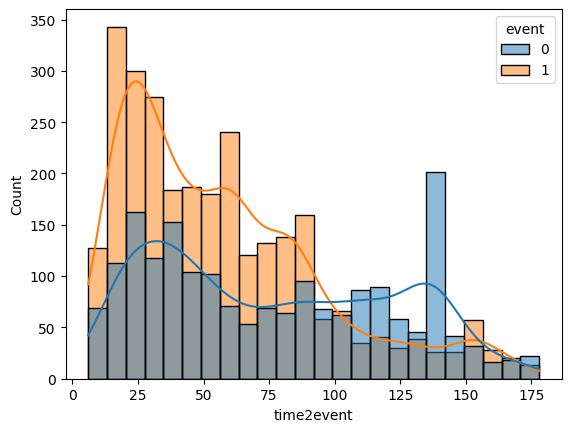

In [317]:
sns.histplot(data = df, x= 'time2event', hue='event', kde=True)

In [318]:
df[df['event'] == 0]['time2event'].describe()

count    1913.000000
mean       76.857815
std        45.334481
min         6.000000
25%        36.000000
50%        73.000000
75%       118.000000
max       178.000000
Name: time2event, dtype: float64

In [319]:
df[df['event'] == 1]['time2event'].describe()

count    2826.000000
mean       57.195329
std        38.290886
min         6.000000
25%        26.000000
50%        48.000000
75%        80.000000
max       178.000000
Name: time2event, dtype: float64

In [320]:
# time2event mode for properties not sold
df[df['event'] == 0]['time2event'].mode()

0    137
Name: time2event, dtype: int64

In [321]:
#Analyzing records where time to event is 137 days, which is the mode
df[(df['event'] == 0) & (df['time2event'] == 137)].head(5)

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,last_price,price_change_pct,longitude,latitude,views,num_marketplaces_property_at,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
9,0,137,0,88.0,2.0,2.0,0,461,1.0,5.7,0.0,-99.185352,19.385228,72,5,1,1,0,1,0,0,0,1,1,0,1
71,0,137,0,90.0,2.5,2.0,0,461,3.0,5.5,0.0,-99.255260,19.378529,8,1,0,1,1,1,0,0,0,1,1,0,1
84,0,137,0,430.0,3.5,3.0,0,282,3.0,16.0,0.0,-99.275786,19.362551,46,3,1,1,1,1,0,0,0,1,1,0,0
98,0,137,1,220.0,3.0,3.0,0,159,3.0,3.0,0.0,-99.254674,19.306518,48,4,0,0,0,0,0,0,0,0,1,0,0
100,0,137,0,56.0,1.0,1.0,0,247,1.0,3.1,0.0,-99.145629,19.433646,58,4,0,1,0,1,0,1,0,1,0,0,0


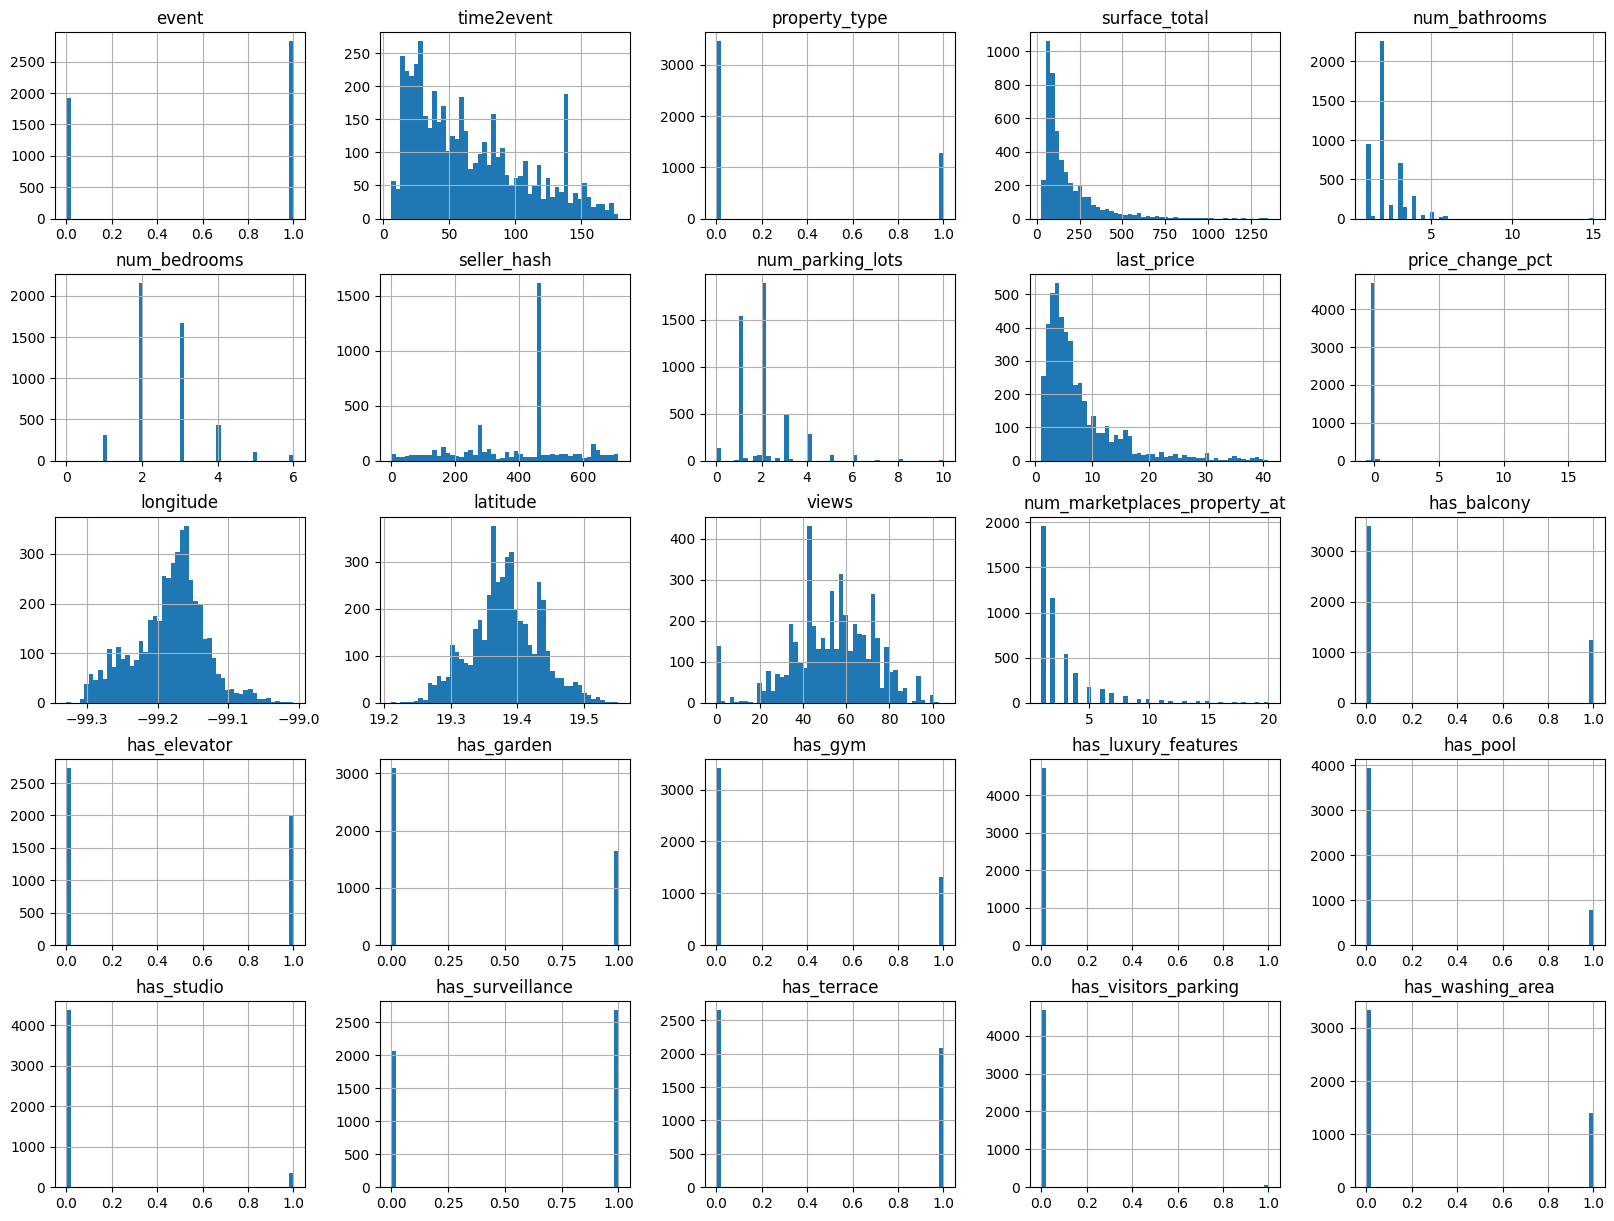

In [322]:
df.hist(bins=50, figsize=(20,15), ec = 'b')
plt.show()

### **Event** Analysis

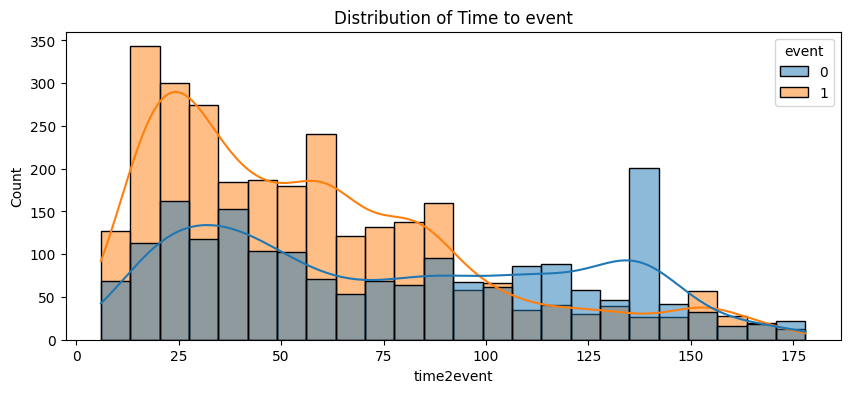

In [323]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of Time to event')
sns.histplot(data=df, x='time2event', hue='event', kde=True)
plt.show()

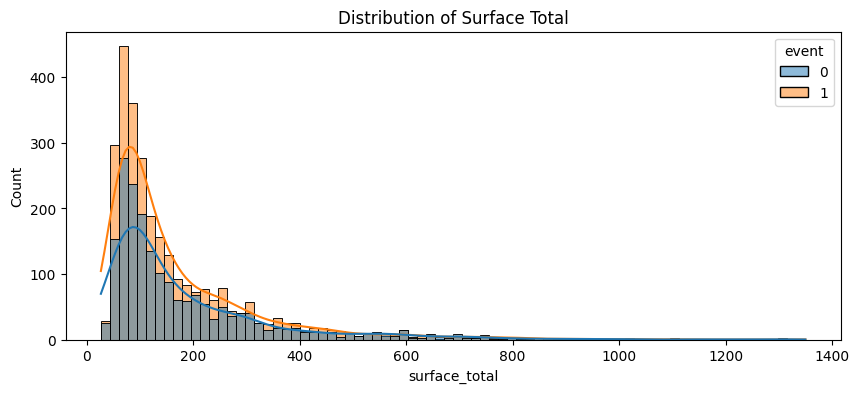

In [324]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of Surface Total')
sns.histplot(data=df, x='surface_total', hue='event', kde=True)
plt.show()

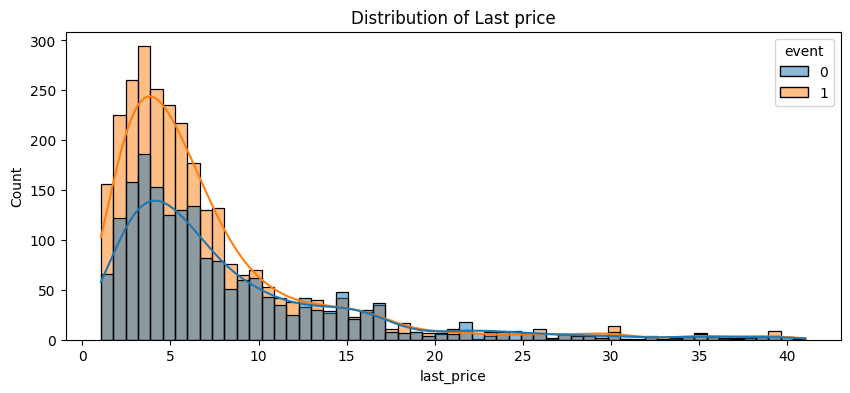

In [325]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of Last price')
sns.histplot(data=df, x='last_price', hue='event', kde=True)
plt.show()

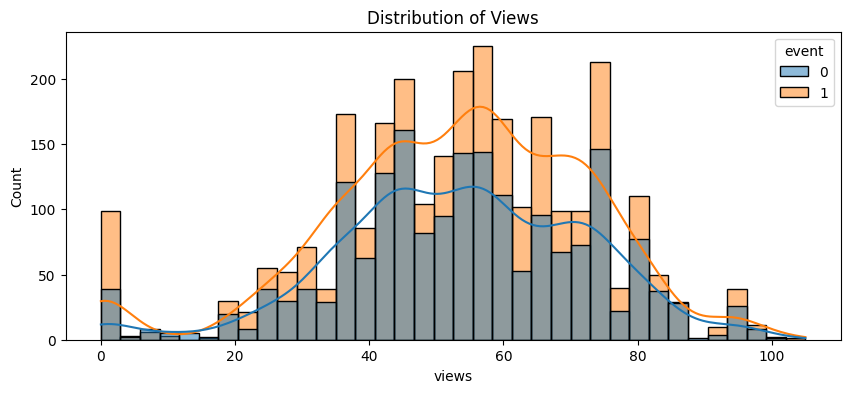

In [326]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of Views')
sns.histplot(data=df, x='views', hue='event', kde=True)
plt.show()

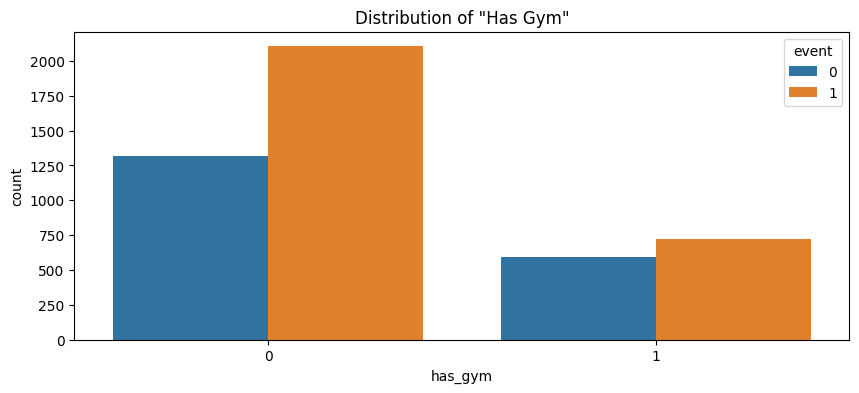

In [327]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of "Has Gym"')
sns.countplot(data=df, x='has_gym', hue='event')
plt.show()

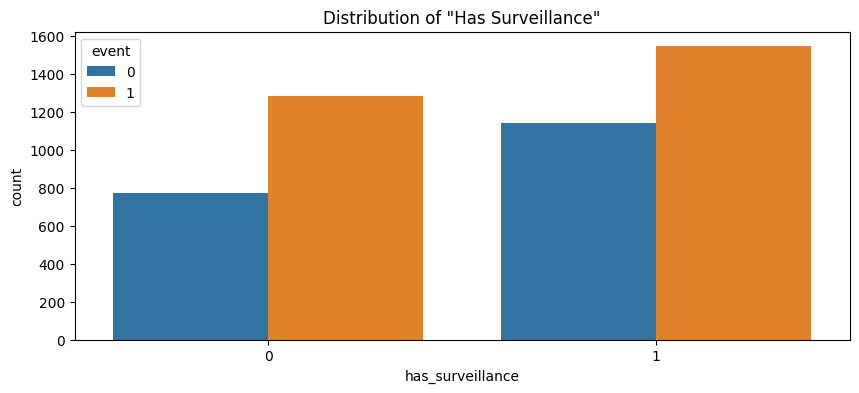

In [328]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of "Has Surveillance"')
sns.countplot(data=df, x='has_surveillance', hue='event')
plt.show()

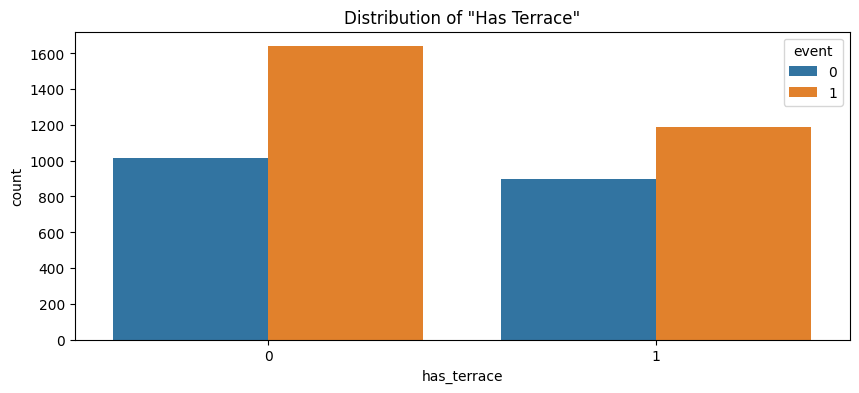

In [329]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of "Has Terrace"')
sns.countplot(data=df, x='has_terrace', hue='event')
plt.show()

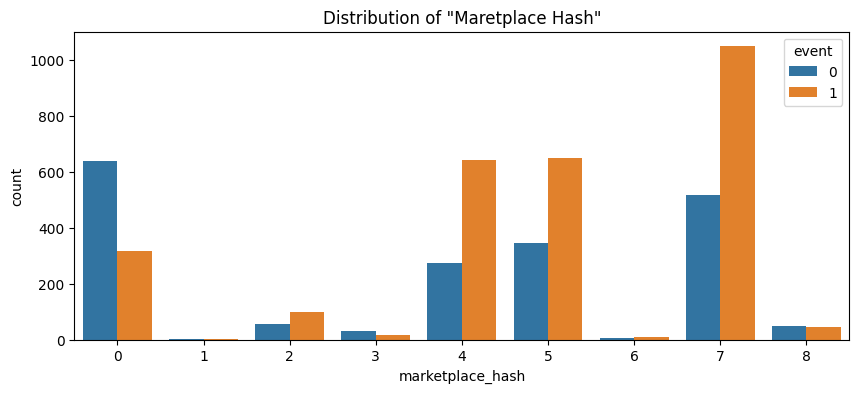

In [330]:
plt.figure(figsize=(10, 4))
plt.title('Distribution of "Maretplace Hash"')
sns.countplot(data=df, x='marketplace_hash', hue='event')
plt.show()

### **time2event** Analysis

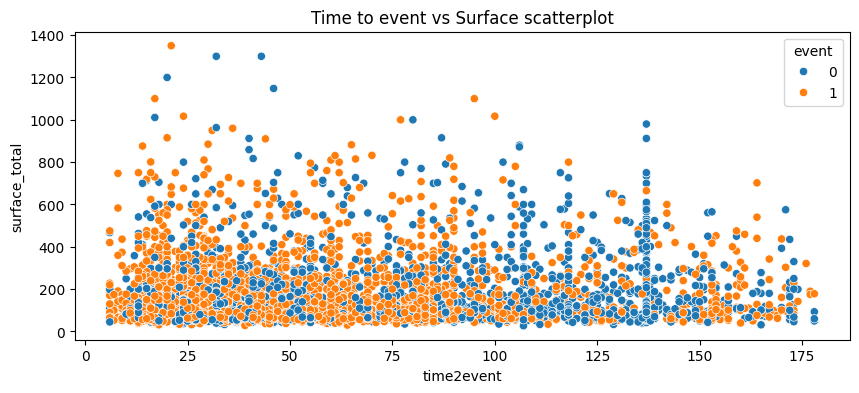

In [331]:
# Distribution of parking spaces
plt.figure(figsize=(10, 4))
plt.title("Time to event vs Surface scatterplot")
sns.scatterplot(data = df, x = 'time2event', y='surface_total', hue = 'event')
plt.show()

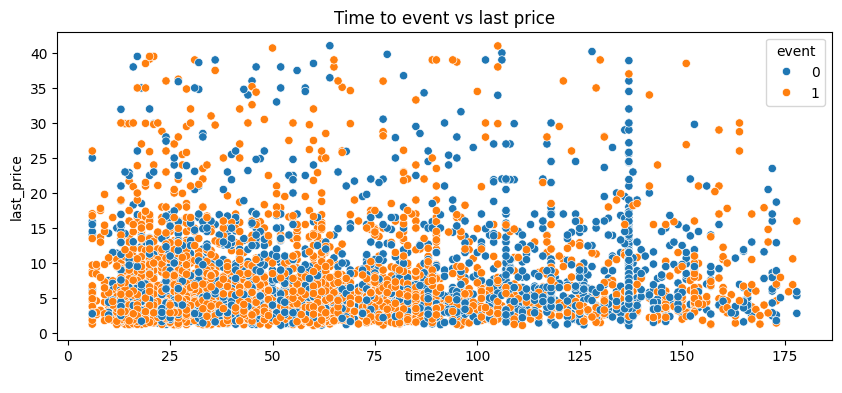

In [332]:
# Distribution of parking spaces
plt.figure(figsize=(10, 4))
plt.title("Time to event vs last price")
sns.scatterplot(data = df, x = 'time2event', y='last_price', hue = 'event')
plt.show()

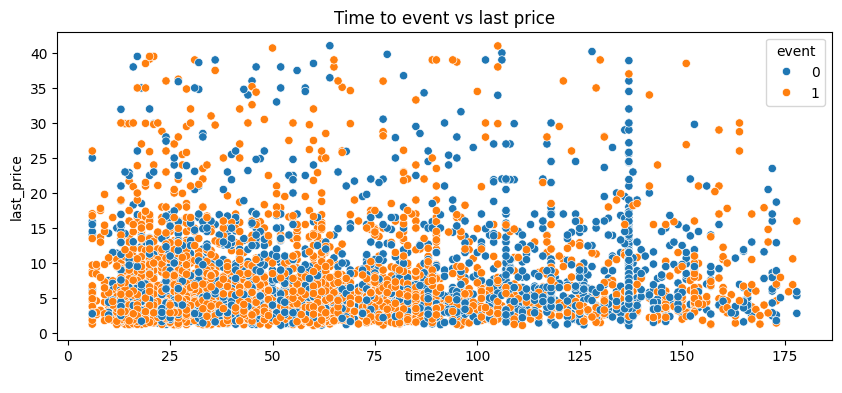

In [333]:
# Distribution of parking spaces
plt.figure(figsize=(10, 4))
plt.title("Time to event vs last price")
sns.scatterplot(data = df, x = 'time2event', y='last_price', hue = 'event')
plt.show()

In [334]:
df.head()

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,last_price,price_change_pct,longitude,latitude,views,num_marketplaces_property_at,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,1,96,0,120.0,2.5,2.0,2,278,1.0,4.100000,0.0,-99.197758,19.377609,51,1,0,1,0,0,0,0,0,0,0,0,0
1,0,37,0,82.0,2.0,2.0,7,339,2.0,4.900000,0.0,-99.183100,19.402272,61,1,1,1,0,0,0,0,0,1,1,0,0
2,1,88,0,84.0,2.0,2.0,4,132,1.0,2.782696,0.0,-99.114488,19.399742,50,3,0,0,0,0,0,0,0,0,0,0,0
3,1,58,0,92.0,2.0,2.0,2,278,0.0,5.280000,0.0,-99.176732,19.395337,68,2,1,1,0,0,0,0,0,1,0,0,0
4,0,95,0,55.0,1.0,1.0,7,461,1.0,3.250000,0.0,-99.145629,19.433646,58,6,0,1,1,1,0,1,0,1,1,0,0


Correlation heatmap

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   event                         4739 non-null   int64  
 1   time2event                    4739 non-null   int64  
 2   property_type                 4739 non-null   int32  
 3   surface_total                 4739 non-null   float64
 4   num_bathrooms                 4739 non-null   float64
 5   num_bedrooms                  4739 non-null   float64
 6   marketplace_hash              4739 non-null   object 
 7   seller_hash                   4739 non-null   int32  
 8   num_parking_lots              4739 non-null   float64
 9   last_price                    4739 non-null   float64
 10  price_change_pct              4739 non-null   float64
 11  longitude                     4739 non-null   float64
 12  latitude                      4739 non-null   float64
 13  vie

In [336]:
df1 = df.drop(columns=['property_type', 'marketplace_hash', 'seller_hash', 'has_balcony', 'has_elevator', 'has_garden', 'has_gym', 'has_luxury_features', 'has_pool', 'has_studio', 'has_surveillance', 'has_terrace', 'has_visitors_parking', 'has_washing_area'])

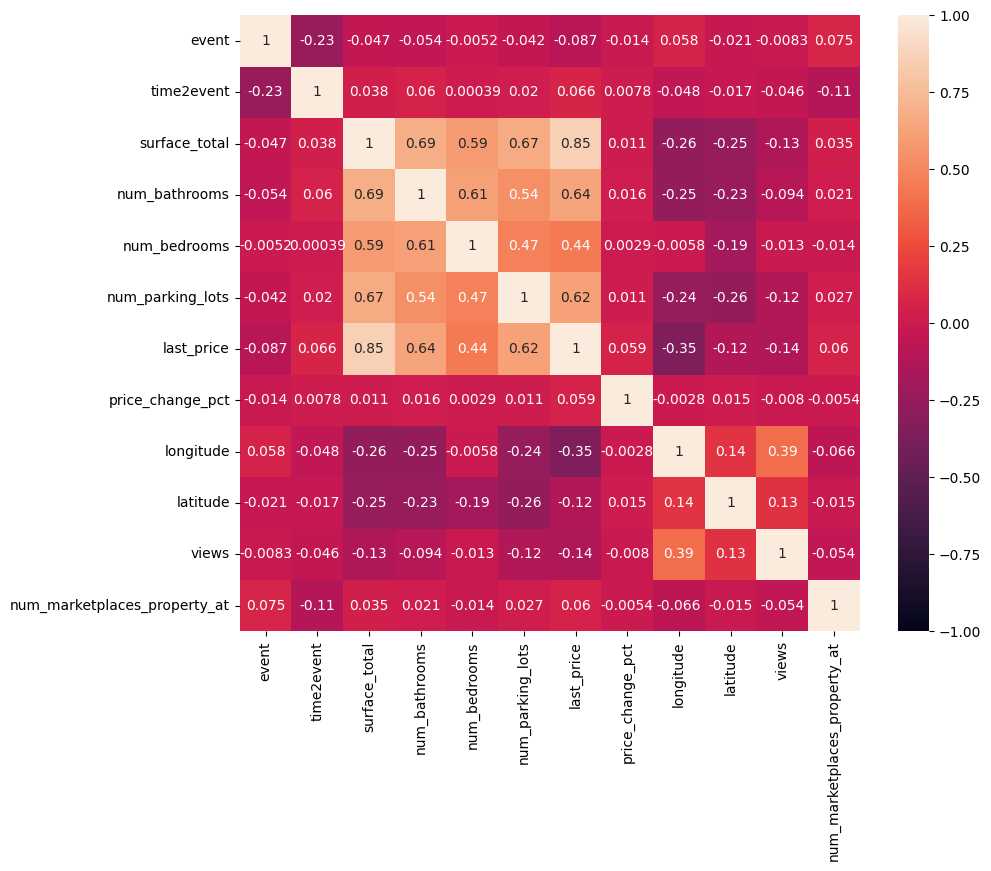

In [337]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True)

## 3. Model training

This problem can be addressed using Survival Analysis, a method used to study the time it takes for a specific event to occur.

#### Options for Survival Analysis

1. **Kaplan-Meier Estimator**  
    - A non-parametric method used to estimate the survival function from lifetime data.  
    - It is useful for visualizing survival probabilities over time but does not account for covariates or predictors.  

2. **Log-Rank Test**  
    - A hypothesis test to compare survival distributions between two or more groups.  
    - It is effective for group comparisons but does not provide a model to estimate survival based on multiple covariates.  

3. **Cox Proportional Hazards Model**  
    - A semi-parametric method that models the hazard rate as a function of covariates.  
    - It allows for the inclusion of multiple predictors and provides insights into how each variable affects the likelihood of the event occurring.  
    - 

### Why Choose the Cox Method?  
For this case, we need to estimate the time to an event (e.g., property sale) based on various parameters (e.g., price, surface area, views). The Cox Proportional Hazards Model is ideal because:  
- It incorporates multiple covariates to predict the event.  
- It does not assume a specific baseline hazard function, making it flexible.  
- It provides interpretable coefficients to understand the impact of each variable on the event likelihood. 

In [339]:
mydf = df.copy()

# Removing time columns
# mydf.drop(columns=['first_observed_date', 'last_observed_date', 'longitude', 'latitude'], inplace=True)
mydf.drop(columns=['longitude', 'latitude'], inplace=True)

In [340]:
mydf.head()

,event,time2event,property_type,surface_total,num_bathrooms,num_bedrooms,marketplace_hash,seller_hash,num_parking_lots,last_price,price_change_pct,views,num_marketplaces_property_at,has_balcony,has_elevator,has_garden,has_gym,has_luxury_features,has_pool,has_studio,has_surveillance,has_terrace,has_visitors_parking,has_washing_area
0,1,96,0,120.0,2.5,2.0,2,278,1.0,4.100000,0.0,51,1,0,1,0,0,0,0,0,0,0,0,0
1,0,37,0,82.0,2.0,2.0,7,339,2.0,4.900000,0.0,61,1,1,1,0,0,0,0,0,1,1,0,0
2,1,88,0,84.0,2.0,2.0,4,132,1.0,2.782696,0.0,50,3,0,0,0,0,0,0,0,0,0,0,0
3,1,58,0,92.0,2.0,2.0,2,278,0.0,5.280000,0.0,68,2,1,1,0,0,0,0,0,1,0,0,0
4,0,95,0,55.0,1.0,1.0,7,461,1.0,3.250000,0.0,58,6,0,1,1,1,0,1,0,1,1,0,0


In [341]:
del cph

In [342]:
cph = CoxPHFitter(alpha=0.05) # 95% confidence interval
cph.fit(mydf, 'time2event', 'event')
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
property_type,-0.046819,0.954260,0.070213,-0.184433,0.090795,0.831575,1.095044,0.0,-0.666823,5.048852e-01,0.985973
surface_total,0.000427,1.000427,0.000326,-0.000211,0.001065,0.999789,1.001066,0.0,1.311480,1.896955e-01,2.398243
num_bathrooms,-0.024099,0.976189,0.030423,-0.083727,0.035528,0.919683,1.036167,0.0,-0.792145,4.282759e-01,1.223387
num_bedrooms,0.022889,1.023153,0.030105,-0.036116,0.081895,0.964528,1.085342,0.0,0.760307,4.470714e-01,1.161423
marketplace_hash,0.109951,1.116223,0.007893,0.094481,0.125421,1.099088,1.133626,0.0,13.929837,4.173051e-44,144.103734
seller_hash,0.000134,1.000134,0.000114,-0.000089,0.000357,0.999911,1.000357,0.0,1.177408,2.390328e-01,2.064719
num_parking_lots,0.008919,1.008959,0.022585,-0.035347,0.053185,0.965270,1.054624,0.0,0.394903,6.929148e-01,0.529250
last_price,-0.028994,0.971422,0.006191,-0.041129,-0.016859,0.959706,0.983282,0.0,-4.682983,2.827297e-06,18.432145
price_change_pct,0.008927,1.008967,0.109608,-0.205901,0.223755,0.813914,1.250765,0.0,0.081445,9.350877e-01,0.096826


In [343]:
cph.summary[cph.summary['p'] < 0.05]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
marketplace_hash,0.109951,1.116223,0.007893,0.094481,0.125421,1.099088,1.133626,0.0,13.929837,4.173051e-44,144.103734
last_price,-0.028994,0.971422,0.006191,-0.041129,-0.016859,0.959706,0.983282,0.0,-4.682983,2.827297e-06,18.432145
num_marketplaces_property_at,0.059803,1.061627,0.006951,0.046179,0.073427,1.047262,1.076190,0.0,8.603455,7.735170e-18,56.843273
has_elevator,-0.134319,0.874311,0.048088,-0.228570,-0.040069,0.795671,0.960723,0.0,-2.793208,5.218818e-03,7.582061


In [344]:
concorcdance = cph.concordance_index_
concordance

0.6314689988960425

In [345]:
import pandas as pd
from lifelines import CoxPHFitter

# ASUMIMOS QUE TU DATAFRAME 'mydf' YA ESTÁ CARGADO Y DISPONIBLE.
# Ejemplo de cómo podría lucir tu 'mydf' (solo para ilustrar):
# data = {
#     'time2event': [10, 20, 30, 15, 25, 35, 40, 50, 60, 22],
#     'event': [1, 0, 1, 1, 0, 1, 0, 1, 0, 1],
#     'property_type': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'A', 'B', 'C'], # Ejemplo categórico
#     'surface_total': [100, 150, 120, 80, 200, 110, 90, 130, 180, 100],
#     'last_price': [500, 700, 600, 400, 800, 550, 450, 650, 750, 520],
#     'views': [50, 30, 80, 20, 90, 60, 25, 70, 40, 75]
#     # ... más covariables
# }
# mydf = pd.DataFrame(data)
# print("DataFrame 'mydf' de ejemplo (primeras filas):")
# print(mydf.head())
# print("-" * 30)

# 1. Preprocesamiento básico de 'mydf' (¡IMPORTANTE!)
# Asegúrate de que 'mydf' exista y no esté vacío
if 'mydf' not in locals() or mydf.empty:
    print("Error: El DataFrame 'mydf' no está definido o está vacío.")
    print("Asegúrate de haber cargado tus datos en 'mydf' antes de ejecutar este bloque.")
    exit()

# Copia para no modificar el DataFrame original directamente, si lo prefieres
df_processed = mydf.copy()

# Convierte 'event' a entero 0/1 si no lo está
if 'event' in df_processed.columns:
    df_processed['event'] = df_processed['event'].astype(int)
else:
    print("Error: La columna 'event' no se encuentra en 'mydf'.")
    exit()

if 'time2event' not in df_processed.columns:
    print("Error: La columna 'time2event' no se encuentra en 'mydf'.")
    exit()

# Define tus covariables basándote en las columnas de 'mydf'.
# Estas son las columnas que tenías en tu imagen de salida anterior.
# Adapta esta lista a las columnas exactas que tienes en 'mydf' y quieres usar.
covariate_columns = [
    'property_type',
    'surface_total',
    'num_bathrooms',
    'num_bedrooms',
    'marketplace_hash',
    'seller_hash',
    'num_parking_lots',
    'last_price',
    'price_change_pct',
    'longitude',
    'latitude',
    'views',
    'num_marketplaces_property_at',
    'has_balcony',
    'has_elevator',
    'has_garden',
    'has_gym',
    'has_luxury_features',
    'has_pool',
    'has_studio',
    'has_surveillance',
    'has_terrace',
    'has_visitors_parking',
    'has_washing_area'
]

# Filtra solo las columnas de covariables que realmente existen en 'mydf'
existing_covariate_columns = [col for col in covariate_columns if col in df_processed.columns]
if len(existing_covariate_columns) != len(covariate_columns):
    missing_cols = set(covariate_columns) - set(existing_covariate_columns)
    print(f"Advertencia: Las siguientes columnas esperadas no se encontraron en 'mydf' y serán omitidas: {missing_cols}")

# Columnas finales para el modelo
columns_for_model = ['time2event', 'event'] + existing_covariate_columns
df_for_model = df_processed[columns_for_model]


# NOTA SOBRE VARIABLES CATEGÓRICAS:
# Si 'property_type' (o cualquier otra covariable en 'existing_covariate_columns')
# es categórica (tipo 'object' o 'category'), necesitarás convertirla a variables dummy.
# Ejemplo usando pandas get_dummies:
for col_name in existing_covariate_columns:
    if df_for_model[col_name].dtype == 'object' or isinstance(df_for_model[col_name].dtype, pd.CategoricalDtype):
        print(f"Codificando la variable categórica: {col_name}")
        df_for_model = pd.get_dummies(df_for_model, columns=[col_name], drop_first=True)
        # drop_first=True ayuda a evitar multicolinealidad perfecta


# Manejo de valores faltantes (ejemplo: eliminar filas con NaN en las columnas seleccionadas)
df_for_model_cleaned = df_for_model.dropna()

# Verifica que queden datos después de eliminar NaNs
if df_for_model_cleaned.empty:
    print("Error: El DataFrame 'df_for_model_cleaned' está vacío después de seleccionar columnas y eliminar NaNs.")
    print("Verifica tu DataFrame 'mydf', los nombres de las columnas y el manejo de faltantes.")
    exit()

# Verifica que 'time2event' y 'event' sigan presentes después de get_dummies y dropna
if 'time2event' not in df_for_model_cleaned.columns or 'event' not in df_for_model_cleaned.columns:
    print("Error: 'time2event' o 'event' se perdieron después del preprocesamiento. Revisa los pasos de get_dummies y dropna.")
    # Esto podría pasar si 'time2event' o 'event' eran categóricas y se eliminaron o si todas las filas tenían NaN.
    exit()


# 2. Crea e instancia el modelo CoxPH
cph2 = CoxPHFitter()

# 3. Ajusta el modelo
try:
    # Asegúrate de que las columnas usadas como covariables (después de get_dummies) no incluyan 'time2event' o 'event'
    # 'lifelines' tomará todas las columnas excepto 'duration_col' y 'event_col' como covariables.
    cph2.fit(df_for_model_cleaned, duration_col='time2event', event_col='event')

    # 4. Muestra el resumen
    # print("\n--- Resumen del Modelo de Cox (usando el DataFrame 'mydf') ---")
    # cph2.print_summary(decimals=6) # Ajusta los decimales como en tu imagen
    # print("--- Fin del Resumen ---")

except Exception as e:
    None
#     print(f"Ocurrió un error durante el ajuste del modelo o al imprimir el resumen: {e}")
#     print("Verifica lo siguiente:")
#     print("1. Que las columnas 'time2event' y 'event' en 'mydf' tengan datos numéricos adecuados.")
#     print("2. Que todas las covariables (después de la codificación de categóricas) sean numéricas.")
#     print("3. Que no haya problemas de colinealidad perfecta si el error lo sugiere (ej. después de get_dummies sin drop_first).")
#     print("4. Que haya suficientes datos y variación en 'mydf' después de la limpieza.")

Advertencia: Las siguientes columnas esperadas no se encontraron en 'mydf' y serán omitidas: {'longitude', 'latitude'}
Codificando la variable categórica: marketplace_hash


In [346]:
concorcdance = cph2.concordance_index_
concordance

0.6314689988960425

## Other model

In [347]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# Suponiendo que tu DataFrame se llama df
# Variables de entrada (X) y de salida (y)
X = mydf.drop(columns=["time2event", "event"])
y = Surv.from_dataframe("event", "time2event", mydf)  # convierte a formato estructurado

# División train/test (opcional pero recomendable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train, y_train)


RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [348]:
from sksurv.metrics import concordance_index_censored

# Predicciones de riesgo (cuanto mayor, mayor riesgo de evento pronto)
risk_scores = rsf.predict(X_test)

# Calcular el c-index
c_index, concordant, discordant, tied_risk, tied_time = concordance_index_censored(
    y_test["event"], y_test["time2event"], risk_scores
)

print(f"C-Index: {c_index:.4f}")


C-Index: 0.6458
